In [197]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel

sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os
import sys
sys.path.append('../common_scripts')

from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

from zenodo_get import zenodo_get

In [198]:
## Some helpful functions in plotting 
def interquartile(df):

    # Set the lower and upper quantile thresholds (25% and 75%)
    lower_quantile = 0.01
    upper_quantile = 0.99

    # Filter the DataFrame based on the quantile range for all columns
    filtered_df = df[
        (df >= df.quantile(lower_quantile)) &
        (df <= df.quantile(upper_quantile))
    ]

    # Drop rows with any NaN values (if needed)
    #filtered_df = filtered_df.dropna(axis = 1)

    return filtered_df


## Downloading features from a repository on Zenodo

### Donwloading tsfel features from a 150s window

In [5]:
## Downloading tsfel features


## Downloading the physical features 
## This is doi for physical features (for both 50s and 150s) - 10.5281/zenodo.10689585
## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

doi = '10.5281/zenodo.10689824'  #Downloading tsfel features for 150s length
# Download files from the Zenodo record
files = zenodo_get([doi])

Title: Tsfel Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (150s)
Keywords: 
Publication date: 2024-02-21
DOI: 10.5281/zenodo.10689824
Total size: 1483.0 MB

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part3.csv   size: 411.4 MB

Checksum is correct. (e2699d7b247688adc88aa974053d61a0)

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part2.csv   size: 295.7 MB

Checksum is correct. (0426976c0a13d9e459b730962000b428)

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_explosion_50_100.csv   size: 96.9 MB

Checksum is correct. (03b0d7d98ca50fa6d108ed88297d4c87)

Link: https://zenodo.org/record/10689824/files/tsfel_features_noise_50_100.csv   size: 314.8 MB

Checksum is correct. (74a2bb0aa317db40a35c77aa1a7de922)

Link: https://zenodo.org/record/10689824/files/tsfel_features_exotic_50_100.csv   size: 57.0 MB

Checksum is correct. (98b876afd

### Downloading physical features

In [6]:
## Downloading the physical features 
## This is doi for physical features (for both 50s and 150s) - 10.5281/zenodo.10689585
## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

doi = '10.5281/zenodo.10689585'  #Downloading physical
# Download files from the Zenodo record
files = zenodo_get([doi])

Title: Physical Features for my study on Automatic Seismic Event Classification System in Pacific Northwest
Keywords: 
Publication date: 2024-02-20
DOI: 10.5281/zenodo.10689585
Total size: 375.7 MB

Link: https://zenodo.org/record/10689585/files/physical_features_noise_z_50_100.csv   size: 40.5 MB

Checksum is correct. (731c772d47171f5786caf5ee1d34f8b2)

Link: https://zenodo.org/record/10689585/files/physical_features_comcat_z_earthquake_50_100_part3.csv   size: 38.0 MB

Checksum is correct. (3134dad6f8b5fc6472b52ec82e8ed430)

Link: https://zenodo.org/record/10689585/files/physical_features_exotic_z_10_40.csv   size: 7.1 MB

Checksum is correct. (f3b2f662e920ce728ccd5eff2a422ea1)

Link: https://zenodo.org/record/10689585/files/physical_features_comcat_z_explosion_50_100.csv   size: 12.4 MB

Checksum is correct. (f1db652ed67939ef2c7b62e7eba3895d)

Link: https://zenodo.org/record/10689585/files/physical_features_comcat_z_earthquake_50_100_part2.csv   size: 38.7 MB

Checksum is correct. (

## Loading tsfel features

In [7]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('tsfel_features_exotic_50_100.csv')




# features of noise
features_noise_tsfel = pd.read_csv('tsfel_features_noise_50_100.csv')





# features of explosion
features_explosion_tsfel = pd.read_csv('tsfel_features_comcat_z_explosion_50_100.csv')



# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part1.csv')
features_eq2 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part2.csv')
features_eq3 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part3.csv')



# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3])

## Removing highly correlated tsfel features

In [10]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(features_noise_tsfel.iloc[:, 1:390])


features_exotic_tsfel.drop(corr_features, axis=1, inplace=True)
features_noise_tsfel.drop(corr_features, axis=1, inplace=True)
features_explosion_tsfel.drop(corr_features, axis=1, inplace=True)
features_earthquake_tsfel.drop(corr_features, axis=1, inplace=True)

## We need to define a function to remove highly correlated features from physical features too!

## Loading physical features

In [11]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('physical_features_exotic_z_50_100.csv')

# features of noise
features_noise_physical = pd.read_csv('physical_features_noise_z_50_100.csv')


# features of explosion
features_explosion_physical = pd.read_csv('physical_features_comcat_z_explosion_50_100.csv')

# features of earthquakes
features_eq1 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part1.csv')
features_eq2 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part2.csv')
features_eq3 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part3.csv')
features_eq4 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part4.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])








## Removing the large files from the directory

The features files we downloaded are very large in size. This will create problems when uploading to github repository so once we store the features in variable we will remove these files

In [14]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## Merging tsfel and physical features

In [15]:
# Each event is identified by a serial number. The serial number is the iteration number when we iterated through 
# the catalog, since tsfel and physical features were extracted separately, we have to merge them together. 
features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = 'serial_no')
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = 'serial_no')
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = 'serial_no')



# The exotic events further contains three classes - (i) surface, (ii) sonic and (iii) thunder
# since sonic and thunder contain very few events, we are going to exclude them fron our analysis from now on. 
features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = 'serial_no')
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = 'serial_no')
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = 'serial_no')


## Concatenating all the features from all classes. 
features_all = pd.concat([features_surface, features_sonic, features_thunder, features_noise, features_explosion, features_earthquake])

In [16]:
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x'], axis = 1)
features_all.rename(columns={'source_y': 'source'}, inplace=True)
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 240898 events and each event have 331 features


## Preprocessing the input features

In [17]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()


## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


## dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240543 events and each event have 330 features


## Dropping the columns that contain same values for all the events, as these features do not really contribute in classification

In [18]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240543 events and each event have 316 features


## Removing the outliers

In [22]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 4

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(len(features_all))
print(len(outliers_removed_df))


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


240543
172665


## Standardizing the features

In [37]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


#We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


                       Feature         Mean     Std Dev
0                  RappMaxMean    22.575937   16.419466
1                RappMaxMedian    63.834727  136.654765
2                        AsDec     0.909845    1.097600
3                     KurtoSig    54.478770   61.446183
4                     KurtoEnv    55.242929   54.918849
..                         ...          ...         ...
309              0_Median diff     0.000013    0.000139
310  0_Negative turning points  1104.651151  179.114040
311      0_Neighbourhood peaks   577.355202   83.654089
312    0_Peak to peak distance     1.847835    0.106387
313       0_Zero crossing rate  1427.796398  391.521056

[314 rows x 3 columns]


## Merging the Metadata information with features

In [38]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Adding Hour of the Day, Days of Week and Month of Year as additional features as they have shown to significantly increase the performance of the machine learning model

In [39]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 172665/172665 [00:01<00:00, 145776.56it/s]


## Standardizing the features

In [61]:
temp_X = X_final.iloc[:,0:314]
#temp_X = temp_X.assign(hod=X_final['hour_of_day'].values, dow=X_final['day_of_week'].values, moy=X_final['month_of_year'].values)



# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(temp_X)

# Create a new DataFrame with scaled features
temp_X = pd.DataFrame(scaled_features, columns= temp_X.columns)



/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


## Hyperparameter tuning of the random forest model for binary classification

In [59]:
# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':0, 'noise':0})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=2, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best Accuracy: 0.9227006431538974
Test Accuracy: 0.9183333333333333


## Performance with the best model

Text(0.5, 1.0, 'Total samples: 1200')

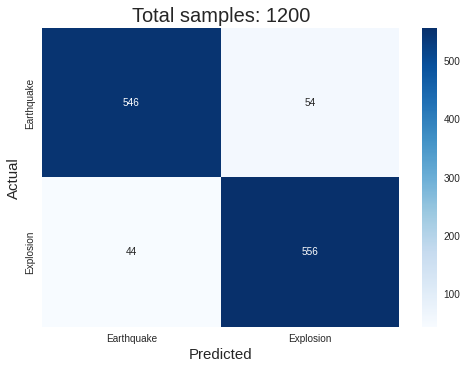

In [60]:
## Performance with best model

plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)


labels = ['Earthquake', 'Explosion']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)



## Classification report with the best model

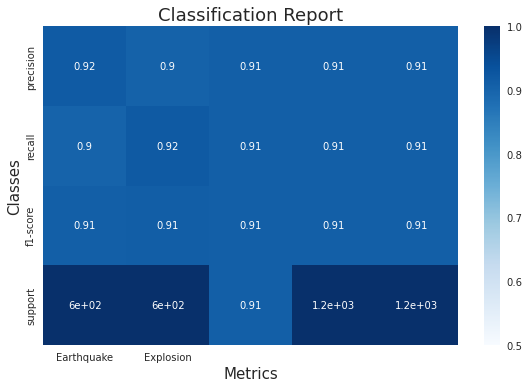

In [57]:
# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
labels = ['Earthquake', 'Explosion']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report), annot=True, cmap='Blues', xticklabels=labels, vmin=0.5, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Computing the feature importance

In [63]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':0, 'noise':0})
    X_resampled, y_resampled = rus.fit_resample(temp_X, y)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    # Perform randomized grid search cross-validation
    best_model.fit(X_train, y_train)


    f_imp.append(best_model.feature_importances_)

 90%|█████████ | 9/10 [02:15<00:14, 14.98s/it]

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  14.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  37.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   9.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  36.1s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   8.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   7.3s
[CV] END bootstrap=False, max_depth=20, 

[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  14.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  15.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  29.0s
[CV] END bootstrap=True, max_depth=30, ma

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  14.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  37.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   9.5s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   7.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  22.3s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.1s
[CV] END bootstrap=True, max_depth=30

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  35.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  14.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  21.8s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  17.4s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  11.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  12.1s
[CV] END bootstrap=False, max_depth=4

100%|██████████| 10/10 [02:30<00:00, 15.05s/it]


,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,E_0.1_1,E_1_3,E_3_10,E_10_20,E_20_50,Kurt_0.1_1,Kurt_1_3,Kurt_3_10,Kurt_10_20,Kurt_20_50,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coeffici

In [65]:
final_imp = np.mean(f_imp, axis = 0)
features = X_train.columns.values
feature_colors = ['darkred']*60+['darkblue']*(len(features)-60)  # red for physical and blue for tsfel features. 


[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  14.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  35.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  23.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  10.7s
[CV] END bootstrap=True, max_depth=None,

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  14.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  35.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   7.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  10.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  12.0s
[CV] END bootstrap=False, max_depth=4

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   9.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  13.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  36.0s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  11.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  23.3s
[CV] END bootstrap=False, max_depth=Non

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  11.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   9.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   8.8s
[CV] END bootstrap=False, max_depth=40, 

In [66]:
# Save the array to disk
np.save('../results/final_imp_binary.npy', final_imp)

In [93]:
final_imp = np.load('../results/final_imp_binary.npy')
features = X_train.columns.values
feature_colors = ['darkred']*60+['darkblue']*(len(features)-60)

In [94]:
# Removing the initial number from the tsfel features names
new_features = []
for i in range(len(features)):
    try:
        new_features.append(features[i].split('0_')[1])
    except:
        new_features.append(features[i].split('0_')[0])

## Plotting the most important features for binary discrimination

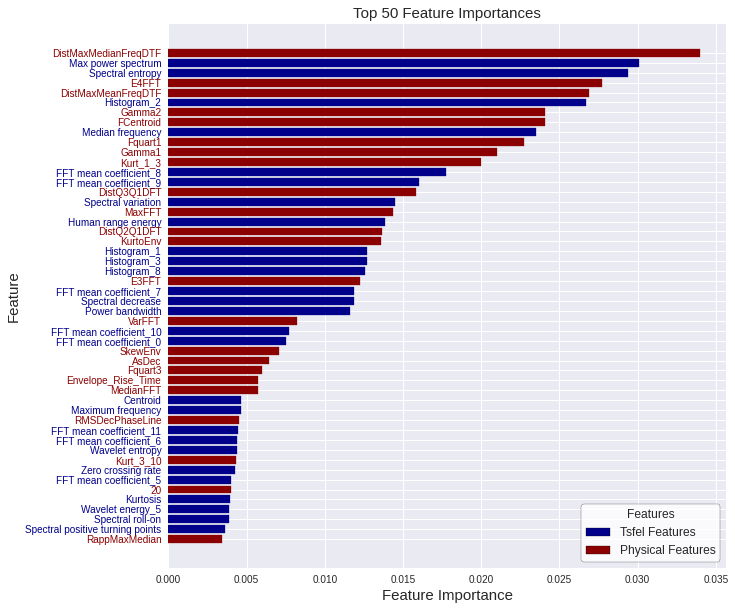

In [95]:
# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = new_features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 10))
bars = plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50])

# Color bars to match yticklabels
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Color yticklabels
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='darkblue', ec='black'), plt.Rectangle((0,0),1,1, color='darkred', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', fontsize='large', title_fontsize='large', frameon=True, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 50 Feature Importances', fontsize=15)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()


## Plotting the distribution of Imp features

/tmp/ipykernel_605067/3690293484.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df >= df.quantile(lower_quantile)) &
/tmp/ipykernel_605067/3690293484.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df <= df.quantile(upper_quantile))


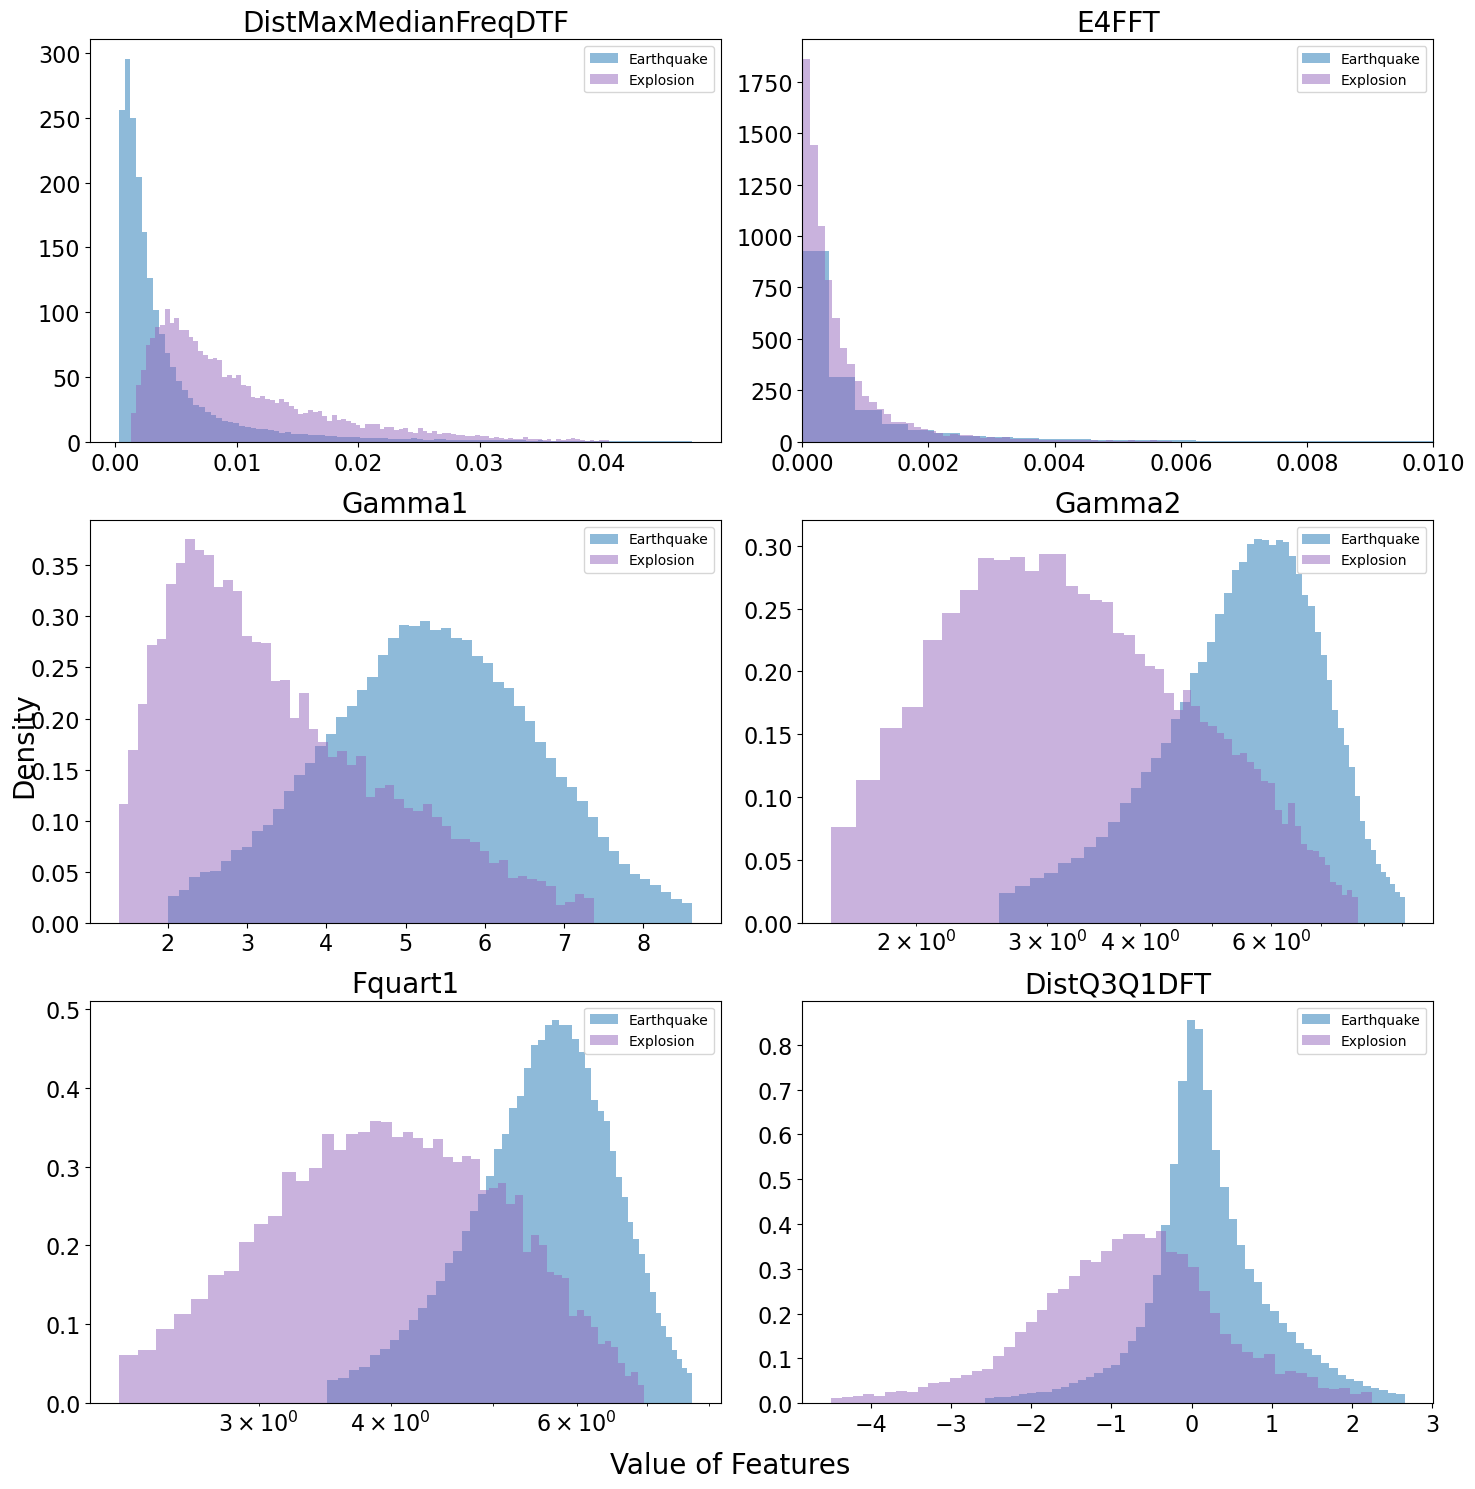

In [96]:
no_df = features_noise_physical
eq_df = features_earthquake_physical
su_df = features_exotic_physical[features_exotic_physical['source'] == 'surface']
exp_df = features_explosion_physical


filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


plt.style.use('default')
# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size for ytick labels

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = [15,15])

feature = 'DistMaxMedianFreqDTF' ## The time taken to reach the maximum amplitude of Envelope


l1 = 0
l2 = 1000

#all_df = features_all
#data_range = all_df[feature].values.ptp()
num_bins = 100 #int(np.ceil(data_range / 0.5))
#ax[0,0].hist(x= filtered_no[feature].values, bins= num_bins, density = True,
#          color =  '#d62728', alpha = 0.5,label = 'Noise')
#ax[0,0].hist(x= filtered_su[feature].values, bins= num_bins,density = True,    
#          color = '#2ca02c', alpha = 0.5, label = 'Surface')
ax[0,0].hist(x= filtered_eq[feature].values, bins= num_bins,density = True,  
               color = '#1f77b4', alpha = 0.5, label = 'Earthquake')
ax[0,0].hist(x= filtered_exp[feature].values, bins=num_bins,density = True,  
   color = '#9467bd', alpha = 0.5, label = 'Explosion')

ax[0,0].legend()
#ax[0,0].set_xscale('log')
#ax[0,0].set_yscale('log')
#ax[0,0].set_xlim(l1,l2)


ax[0,0].set_title(feature, fontsize = 20)


feature = 'E4FFT' ## The time taken to reach the maximum amplitude of Envelope


l1 = 0
l2 = 0.01

#all_df = features_all
#data_range = all_df[feature].values.ptp()
num_bins = 100 #int(np.ceil(data_range / 0.5))
#ax[0,1].hist(x= filtered_no[feature].values, bins= num_bins, density = True,
#          color =  '#d62728', alpha = 0.5,label = 'Noise')
#ax[0,1].hist(x= filtered_su[feature].values, bins= num_bins,density = True,    
#          color = '#2ca02c', alpha = 0.5, label = 'Surface')
ax[0,1].hist(x= filtered_eq[feature].values, bins= num_bins+2900,density = True,  
               color = '#1f77b4', alpha = 0.5, label = 'Earthquake')
ax[0,1].hist(x= filtered_exp[feature].values, bins=num_bins - 50,density = True,  
   color = '#9467bd', alpha = 0.5, label = 'Explosion')

ax[0,1].legend()
#ax[0,1].set_xscale('log')
#ax[0,1].set_yscale('log')
ax[0,1].set_xlim(l1,l2)


ax[0,1].set_title(feature, fontsize = 20)



feature = 'Gamma1' ## The Kurtosis of envelope


l1 = 0
l2 = 10

#all_df = features_all
#data_range = all_df[feature].values.ptp()
num_bins = 50 #int(np.ceil(data_range / 0.5))
#ax[1,0].hist(x= filtered_no[feature].values, bins= 400, density = True,
#          color =  '#d62728', alpha = 0.5,label = 'Noise')
#ax[1,0].hist(x= filtered_su[feature].values, bins= 50,density = True,    
#          color = '#2ca02c', alpha = 0.5, label = 'Surface')
ax[1,0].hist(x= filtered_eq[feature].values, bins= 50,density = True,  
               color = '#1f77b4', alpha = 0.5, label = 'Earthquake')
ax[1,0].hist(x= filtered_exp[feature].values, bins= 50,density = True,  
   color = '#9467bd', alpha = 0.5, label = 'Explosion')

ax[1,0].legend()
#ax[1,0].set_yscale('log')
#ax[1,0].set_xscale('log')
#ax[1,0].set_xlim(l1,l2)


ax[1,0].set_title(feature, fontsize = 20)



feature = 'Gamma2' ## ratio of Max over median of envelope


l1 = 0
l2 = 0.01

#all_df = features_all
#data_range = all_df[feature].values.ptp()
num_bins = 50 #int(np.ceil(data_range / 0.5))
#ax[1,1].hist(x= filtered_no[feature].values, bins= 500, density = True,
#          color =  '#d62728', alpha = 0.5,label = 'Noise')
#ax[1,1].hist(x= filtered_su[feature].values, bins= num_bins,density = True,    
#          color = '#2ca02c', alpha = 0.5, label = 'Surface')
ax[1,1].hist(x= filtered_eq[feature].values, bins= 50,density = True,  
               color = '#1f77b4', alpha = 0.5, label = 'Earthquake')
ax[1,1].hist(x= filtered_exp[feature].values, bins=num_bins,density = True,  
   color = '#9467bd', alpha = 0.5, label = 'Explosion')

ax[1,1].legend(loc = 'upper right')
ax[1,1].set_xscale('log')
#ax[1,1].set_yscale('log')
#ax[1,1].set_xlim(l1,l2)


ax[1,1].set_title(feature, fontsize = 20)


feature = 'Fquart1' ## ratio of Max over median of envelope


l1 = 0
l2 = 0.01

#all_df = features_all
#data_range = all_df[feature].values.ptp()
num_bins = 50 #int(np.ceil(data_range / 0.5))
#ax[1,1].hist(x= filtered_no[feature].values, bins= 500, density = True,
#          color =  '#d62728', alpha = 0.5,label = 'Noise')
#ax[1,1].hist(x= filtered_su[feature].values, bins= num_bins,density = True,    
#          color = '#2ca02c', alpha = 0.5, label = 'Surface')
ax[2,0].hist(x= filtered_eq[feature].values, bins= 50,density = True,  
               color = '#1f77b4', alpha = 0.5, label = 'Earthquake')
ax[2,0].hist(x= filtered_exp[feature].values, bins=num_bins,density = True,  
   color = '#9467bd', alpha = 0.5, label = 'Explosion')

ax[2,0].legend(loc = 'upper right')
ax[2,0].set_xscale('log')
#ax[1,1].set_yscale('log')
#ax[1,1].set_xlim(l1,l2)


ax[2,0].set_title(feature, fontsize = 20)




feature = 'DistQ3Q1DFT' ## ratio of Max over median of envelope


l1 = 0
l2 = 0.01

#all_df = features_all
#data_range = all_df[feature].values.ptp()
num_bins = 50 #int(np.ceil(data_range / 0.5))
#ax[1,1].hist(x= filtered_no[feature].values, bins= 500, density = True,
#          color =  '#d62728', alpha = 0.5,label = 'Noise')
#ax[1,1].hist(x= filtered_su[feature].values, bins= num_bins,density = True,    
#          color = '#2ca02c', alpha = 0.5, label = 'Surface')
ax[2,1].hist(x= filtered_eq[feature].values, bins= 50,density = True,  
               color = '#1f77b4', alpha = 0.5, label = 'Earthquake')
ax[2,1].hist(x= filtered_exp[feature].values, bins=num_bins,density = True,  
   color = '#9467bd', alpha = 0.5, label = 'Explosion')

ax[2,1].legend(loc = 'upper right')
#ax[2,1].set_xscale('log')
#ax[1,1].set_yscale('log')
#ax[1,1].set_xlim(l1,l2)


ax[2,1].set_title(feature, fontsize = 20)






fig.supylabel('Density', fontsize = 20)
fig.supxlabel('Value of Features', fontsize = 20)
fig.tight_layout()

### Plotting the most important tsfel features

/tmp/ipykernel_605067/3690293484.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df >= df.quantile(lower_quantile)) &
/tmp/ipykernel_605067/3690293484.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df <= df.quantile(upper_quantile))


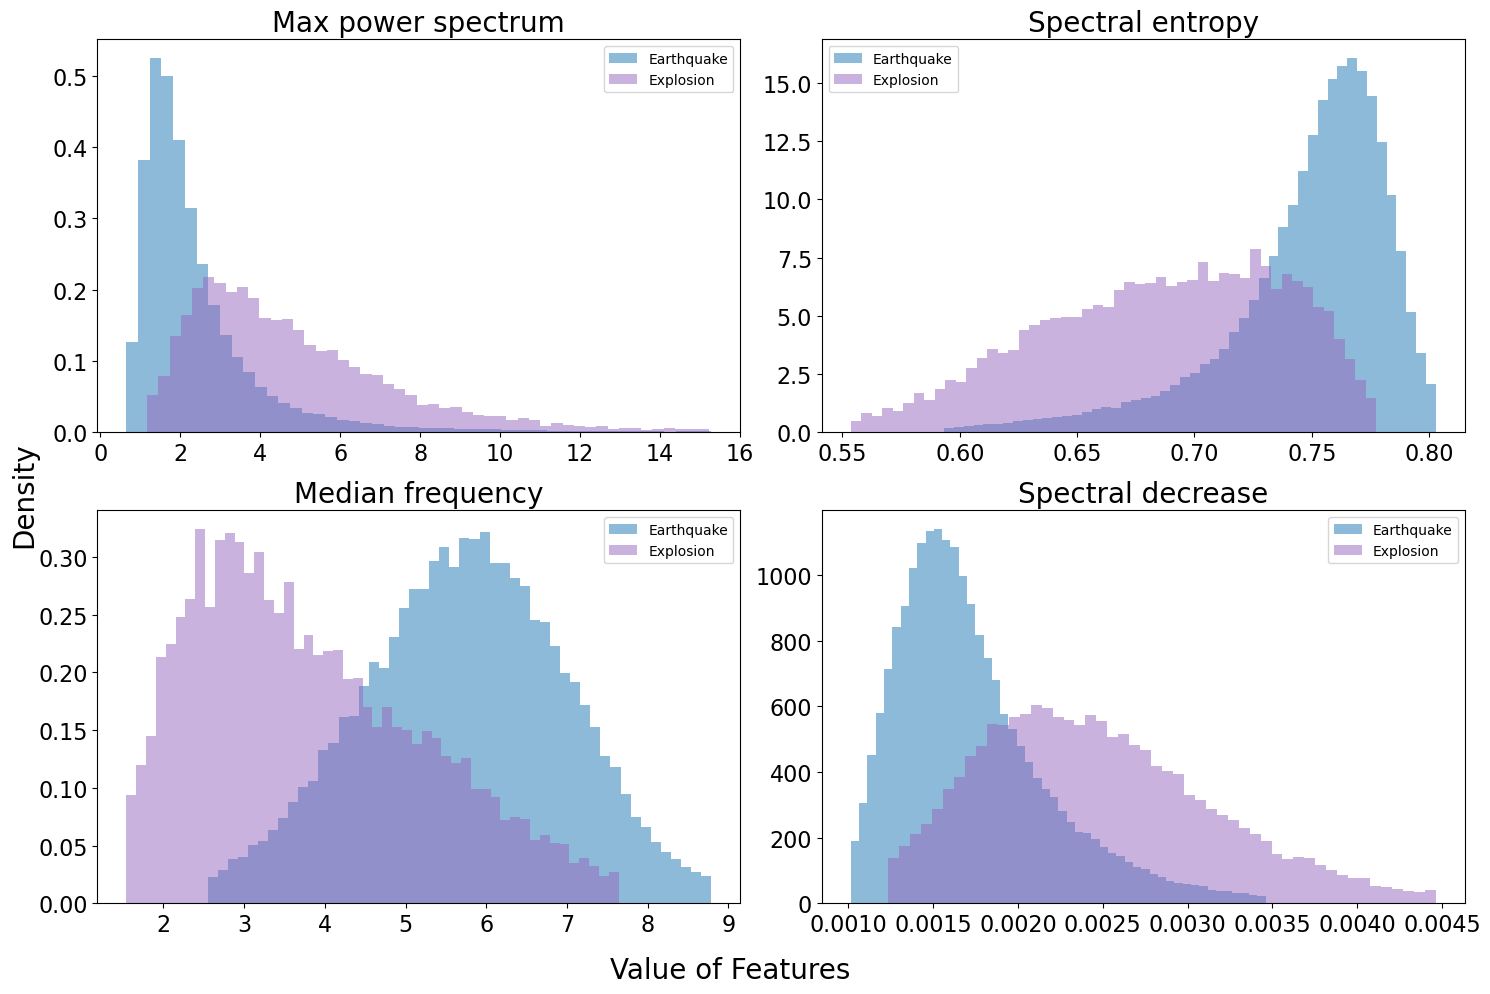

In [104]:
no_df = features_noise_tsfel
eq_df = features_earthquake_tsfel
su_df = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
exp_df = features_explosion_tsfel

filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


# Define a function for histogram plotting
def plot_histogram(ax, feature_data, label, color, num_bins, title):
    ax.hist(x=feature_data, bins=num_bins, density=True, color=color, alpha=0.5, label=label)
    ax.legend()
    ax.set_title(title, fontsize=20)

# Define common parameters
num_bins = 50
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[15, 10])

# Define features and labels
features = {
    '0_Max power spectrum': [filtered_eq, filtered_exp],
    '0_Spectral entropy': [filtered_eq, filtered_exp],
    '0_Median frequency': [filtered_eq, filtered_exp],
    '0_Spectral decrease': [filtered_eq, filtered_exp]
}
labels = ['Earthquake', 'Explosion']
colors = ['#1f77b4', '#9467bd']

# Iterate over features and plot histograms
for idx, (feature, (filtered_eq, filtered_exp)) in enumerate(features.items()):
    row = idx // 2
    col = idx % 2
    plot_histogram(ax[row, col], filtered_eq[feature].values, labels[0], colors[0], num_bins, feature.split('_')[1])
    plot_histogram(ax[row, col], filtered_exp[feature].values, labels[1], colors[1], num_bins, feature.split('_')[1])

fig.supylabel('Density', fontsize=20)
fig.supxlabel('Value of Features', fontsize=20)
fig.tight_layout()
plt.show()


## Selecting 5000 random events per class for training and testing on all the remaining data

In [105]:
## extracting metadata information for each kind of source along with features
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']
## removing the ambiguous events
a_eq = a_eq[a_eq['source_type'] != 'explosion']

a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
# removing the ambiguous events. 
a_px = a_px[a_px['source_type'] != 'earthquake']

a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



## extracting the event ids corresponding to each catalog
eq_ids = np.unique(a_eq['event_id'].values)
su_ids = np.unique(a_su['event_id'].values)
no_ids = np.unique(a_no['event_id'].values)
px_ids = np.unique(a_px['event_id'].values)


## defining the events for training and testing in 70:30 ratio


"""

Modifying this section a bit, for a fair comparison to deep neural network. 


train_eq = eq_ids[0:int(0.7*len(eq_ids))]
train_px = px_ids[0:int(0.7*len(px_ids))]
train_su = su_ids[0:int(0.7*len(su_ids))]
train_no = no_ids[0:int(0.7*len(no_ids))]


test_eq = eq_ids[int(0.7*len(eq_ids)):len(eq_ids)]
test_px = px_ids[int(0.7*len(px_ids)):len(px_ids)]
test_su = su_ids[int(0.7*len(su_ids)):len(su_ids)]
test_no = no_ids[int(0.7*len(no_ids)):len(no_ids)]


"""


# Set the seed for reproducibility
np.random.seed(42)



## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px,])

# allocating event id as index
X_final.index = X_final['event_id'].values



In [192]:
# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

## Performance with manual features added

In [106]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:314]
x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:314]
x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



## Training on 5000 traces per class and testing on all the remaining

In [107]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=5, n_estimators=200, random_state=42)

## Trace wise performance

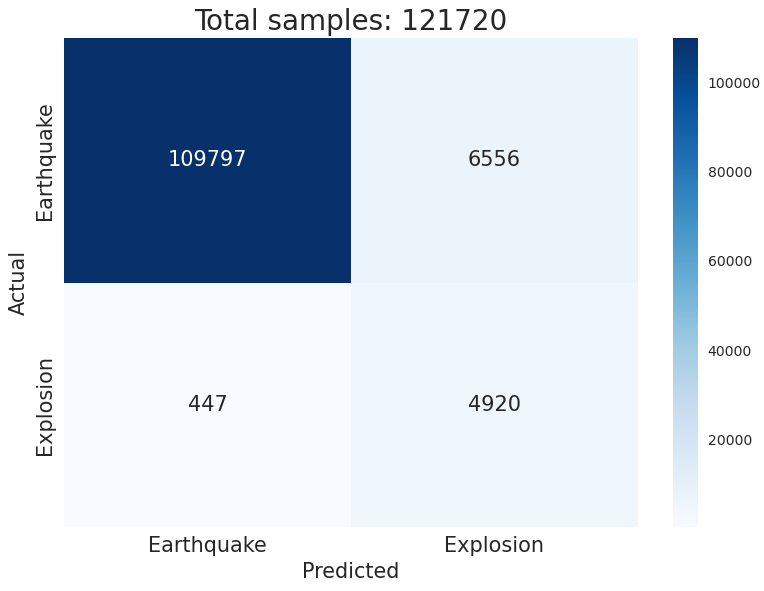

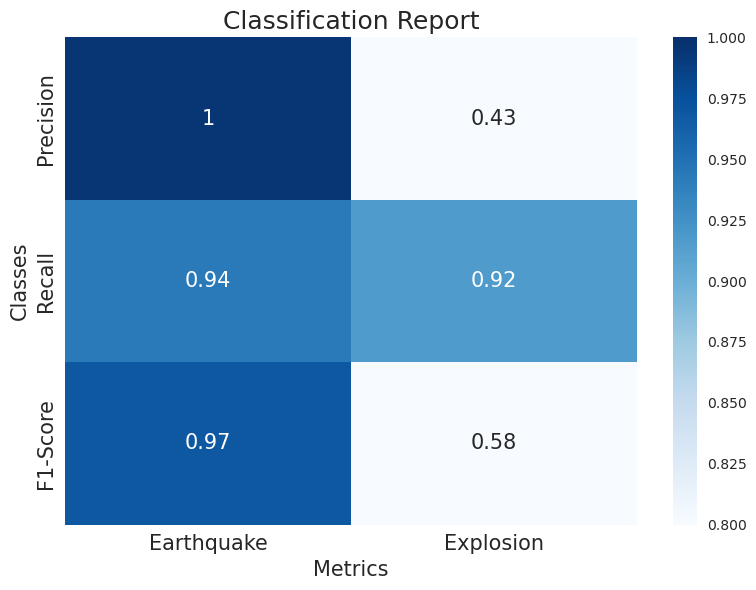

In [109]:
## Trace wise performance 

y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf_man = confusion_matrix(y_num_test, y_pred)


class_labels = ['Earthquake', 'Explosion']
plt.figure(figsize = [8,6])

# Set annotation font size within each block
annot_kws = {"fontsize": 15}
ax = sns.heatmap(trace_cm_phy_tsf_man, annot=True, cmap='Blues', fmt='d', xticklabels = class_labels, yticklabels = class_labels, annot_kws=annot_kws)


# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(class_labels, fontsize=15)


plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)
plt.tight_layout()


# Calculate the classification report
trace_report_phy_tsf_man = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize = [8,6])
ax = sns.heatmap(pd.DataFrame(trace_report_phy_tsf_man).iloc[:3, :2], annot=True, cmap='Blues', yticklabels = labels, xticklabels=class_labels, vmin=0.8, vmax=1, annot_kws=annot_kws)

# Set labels and title
# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(labels, fontsize=15)

ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event Wise performance

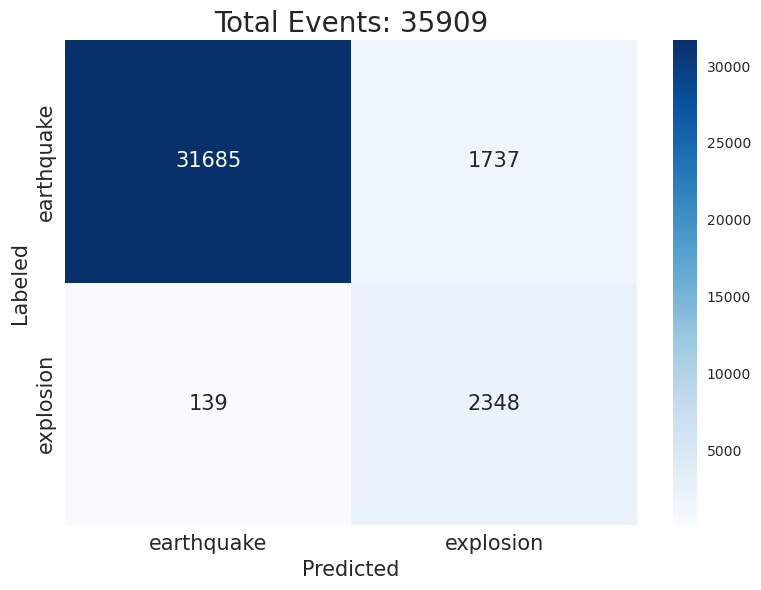

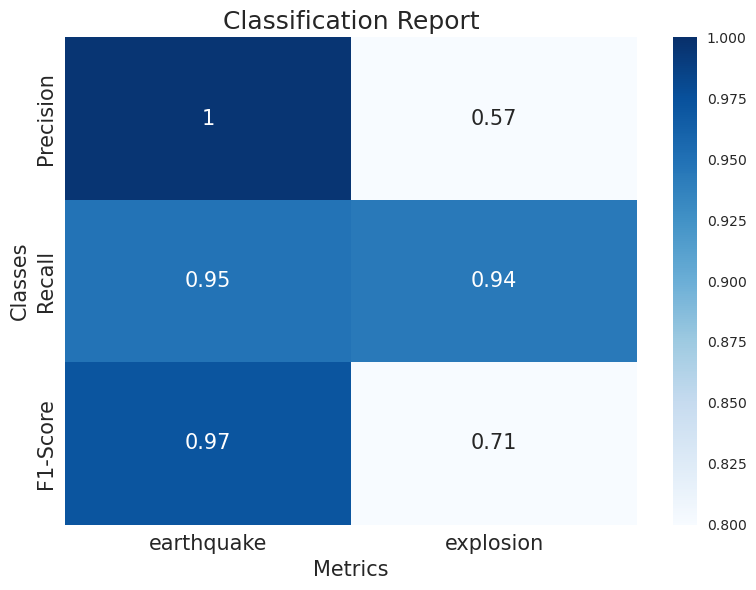

In [194]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]



mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values




## Assigning an event class based on the maximum average probability across the stations. 
temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob]), axis = 0)
## Computing the maximum averaged probability. 
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob]), axis = 0)



cf_events_phy_tsf_man = confusion_matrix(mean_labels, temp_class)
#cf_norm = cf_events/np.sum(cf_events, axis = 1, keepdims = True)
class_labels = ['earthquake','explosion']

plt.figure(figsize = [8, 6])
ax = sns.heatmap(cf_events_phy_tsf_man, annot = True, cmap='Blues', xticklabels = class_labels, yticklabels = class_labels,  fmt="1.0f", annot_kws=annot_kws)
# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(class_labels, fontsize=15)

ax.set_xlabel('Predicted', fontsize = 15)
ax.set_ylabel('Labeled', fontsize = 15)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)
plt.tight_layout()




# Calculate the classification report
report_event_phy_tsf_man = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize = [8,6])
ax = sns.heatmap(pd.DataFrame(report_event_phy_tsf_man).iloc[:3, :2], annot=True, cmap='Blues', yticklabels=labels, xticklabels = class_labels,  vmin=0.8, vmax=1,  annot_kws=annot_kws)

# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(labels, fontsize=15)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Analysis of misclassified events

In [111]:
# probabilities corresponding to misclassified events
misclassified_probs = temp_probs[np.where(mean_labels != temp_class)]

# classification provided to misclassified events
misclassified_class = temp_class[np.where(mean_labels != temp_class)]

# labels provided to misclassified events. 
misclassified_labels = mean_labels[np.where(mean_labels != temp_class)]

# event ids provided to misclassified events. 
misclassified_ids = mean_ids[np.where(mean_labels != temp_class)]

# event ids from misclassified events where mean probabilities exceed 0.8
misclassified_high_prob = misclassified_ids[np.where(misclassified_probs > 0.8)]


# Dataframe of misclassified events
misclassified_X = X_test.loc[misclassified_high_prob]



## New objectives

- download more stations data for each of the misclassified events. 
- extract features
- classify them and see if they still going to be misclassified. 

array(['uw10549413', 'uw10549638', 'uw10550888', ..., 'uw61897761',
       'uw61898816', 'uw61900991'], dtype=object)

In [139]:
mis_ids = X_test.loc[misclassified_ids].groupby(level=0).size()
#indices_with_value_one = misclassified_ids[misclassified_ids == 1].index
single_station_event = mis_ids[mis_ids < 3].index.values

## Downloading more station waveforms for each of the single event. 

In [140]:
X_test.loc[single_station_event]

,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,E_0.1_1,E_1_3,E_3_10,E_10_20,E_20_50,Kurt_0.1_1,Kurt_1_3,Kurt_3_10,Kurt_10_20,Kurt_20_50,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coeffici

In [141]:
starttimes  = X_test.loc[single_station_event]['trace_start_time'].values
source_lats = X_test.loc[single_station_event]['source_latitude_deg'].values
source_lons = X_test.loc[single_station_event]['source_longitude_deg'].values
event_ids = X_test.loc[single_station_event].index.values


In [143]:
client = Client("IRIS")
for i in tqdm(range(len(event_ids))):
    
    try:


        stns = client.get_stations(channel = '*HZ', 
                                starttime=obspy.UTCDateTime(starttimes[i]),
                                endtime= obspy.UTCDateTime(starttimes[i])+150,  
                                latitude= source_lats[i], 
                                longitude = source_lons[i], 
                                minradius= 0, 
                                maxradius= 0.5, 
                                level = 'response'
                             )
        
        for network in stns:
            for station in network:
                for channel in station:
                    st = client.get_waveforms(starttime = obspy.UTCDateTime(starttimes[i]), endtime = obspy.UTCDateTime(starttimes[i]) + 150, network = network.code, station = station.code, channel = channel.code, location = '*')
                    st.write('../data/Binary_Classification/'+event_ids[i]+'_'+network.code+'.'+station.code+'.'+channel.code+'.'+str(starttime)+'.mseed')
                    
                    
    except:
        pass


100%|██████████| 1750/1750 [1:44:40<00:00,  3.59s/it]  


## Results after including more stations per waveform. 

## Data processing

In [144]:
# location of the waveform files in the disk. 
files = glob('../data/binary_classification_waveforms/*.mseed')



### Extracting data from each waveform

In [145]:
data = []
event_ids = []
for file in tqdm(files):
    st = obspy.read(file)
    st.resample(100)
    if len(st[0].data) == 15000:
        event_ids.append(file.split('/')[-1].split('_')[0])
        
        # depending on what features the model was trained on we select the appropriate window. 
        # The current saved model was trained on the 150s window waveforms (P-50, P+100). So we will load those waveforms
        data.append(st[0].data)

100%|██████████| 5538/5538 [00:10<00:00, 531.49it/s]


In [146]:
# stacking the data
data = np.stack(data)

# applying 10% cosine taper before filtering
tapered = apply_cosine_taper(data)

# defining the parameters of the filter. 
lowcut = 1
highcut = 10
num_corners = 4
fs = 100


# Applying bandpass filters
filtered = butterworth_filter(tapered, lowcut, highcut, fs, num_corners, filter_type='bandpass')

# Applying the normalization. 
norm = filtered/np.max(abs(np.stack(filtered)), axis = 1)[:, np.newaxis]

## Extracting tsfel features

In [148]:
code_sttime = time.time()
cfg_file = tsfel.get_features_by_domain()
# Extract features for surface event
features_bin_tsfel = pd.DataFrame([])
for i in tqdm(range(len(norm))):

        df = time_series_features_extractor(cfg_file, norm[i], fs=100, verbose = 0)
        df['event_id'] = event_ids[i]
        features_bin_tsfel = pd.concat([features_bin_tsfel,df])

print(time.time() - code_sttime)

100%|██████████| 3738/3738 [11:41<00:00,  5.33it/s]

701.4036147594452


## Extracting physical features

In [149]:
code_sttime = time.time()
features_bin_physical = pd.DataFrame([])
for i in tqdm(range(len(norm))):
    tr = obspy.Trace(norm[i])
    tr.stats.sampling_rate = 100
    df = seis_feature.compute_physical_features(tr = tr,  envfilter = False)
    df['serial_no'] = i
    df['event_id'] = event_ids[i]
    #df['trace_id'] = trids[i]
    features_bin_physical = pd.concat([features_bin_physical, df])
    
print(time.time() - code_sttime)

  0%|          | 0/3738 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:254: RuntimeWarning: invalid value encountered in double_scalars
  all_attr[0,39] = (all_attr[0,37]**(2) - all_attr[0,38]**(2))**(0.5)
100%|██████████| 3738/3738 [08:08<00:00,  7.65it/s]

488.7387342453003


In [151]:
## Removing the correlated features
features_bin_tsfel.drop(corr_features, axis=1, inplace=True, errors = 'ignore')
final_features_bin = pd.concat([features_bin_tsfel, features_bin_physical], axis = 1)
columns_to_select = scaler_params['Feature'].values
features_bin = final_features_bin.loc[:, columns_to_select]

In [154]:
#for i in range(len(features_bin.columns)):
#    features_bin.iloc[:,i] = (features_bin.iloc[:,i]-scaler_params.iloc[i,1])/(scaler_params.iloc[i,2])
    


In [155]:
hod_bin = []
dow_bin = []
moy_bin = []

for i in range(len(event_ids)):
    value = X_test.loc[event_ids[i]]['hour_of_day']
    hod_bin.append(value if isinstance(value, np.float64) else value.values[0])
    
    value = X_test.loc[event_ids[i]]['day_of_week']
    dow_bin.append(value if isinstance(value, np.int64) else value.values[0])
    
    value = X_test.loc[event_ids[i]]['month_of_year']
    moy_bin.append(value if isinstance(value, np.int64) else value.values[0])


In [156]:
features_bin['hour_of_day'] = hod_bin
features_bin['day_of_week'] = dow_bin
features_bin['month_of_year'] = moy_bin

In [157]:
features_bin


,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,E_0.1_1,E_1_3,E_3_10,E_10_20,E_20_50,Kurt_0.1_1,Kurt_1_3,Kurt_3_10,Kurt_10_20,Kurt_20_50,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coeffici

In [158]:
## Trace wise performance 

y_pred_bin = best_model.predict(features_bin)

In [159]:
features_bin['Eq_prob'] = best_model.predict_proba(features_bin.iloc[:, 0:317])[:,0]
features_bin['Exp_prob'] = best_model.predict_proba(features_bin.iloc[:, 0:317])[:,1]

In [160]:
features_bin['event_id'] = event_ids

In [161]:
event_labels_bin = np.argmax(features_bin.groupby('event_id').mean().iloc[:, 318:320].values, axis = 1)

In [162]:
event_ids_mean = features_bin.groupby('event_id').mean().index.values

In [219]:
features_bin[features_bin['event_id'] == event_ids_mean[4]]

,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,E_0.1_1,E_1_3,E_3_10,E_10_20,E_20_50,Kurt_0.1_1,Kurt_1_3,Kurt_3_10,Kurt_10_20,Kurt_20_50,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coeffici

In [163]:
test_overall = pd.DataFrame([])
test_overall['mean_labels'] = mean_labels
test_overall['mean_ids'] = mean_ids
test_overall['assigned_class'] = temp_class
test_overall.index = mean_ids

In [164]:
for i in range(len(event_ids_mean)):
    test_overall.loc[event_ids_mean[i], 'assigned_class'] = event_labels_bin[i]


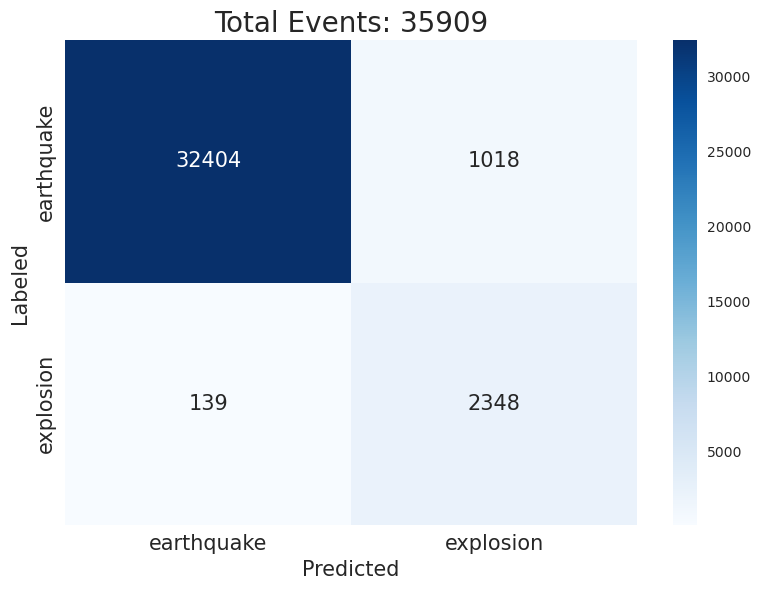

In [165]:
cf_bin = confusion_matrix(test_overall['mean_labels'].values, test_overall['assigned_class'].values)
#cf_norm = cf_events/np.sum(cf_events, axis = 1, keepdims = True)
class_labels = ['earthquake','explosion']

plt.figure(figsize = [8, 6])
ax = sns.heatmap(cf_bin, annot = True, cmap='Blues', xticklabels = class_labels, yticklabels = class_labels,  fmt="1.0f", annot_kws=annot_kws)
# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(class_labels, fontsize=15)

ax.set_xlabel('Predicted', fontsize = 15)
ax.set_ylabel('Labeled', fontsize = 15)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)
plt.tight_layout()


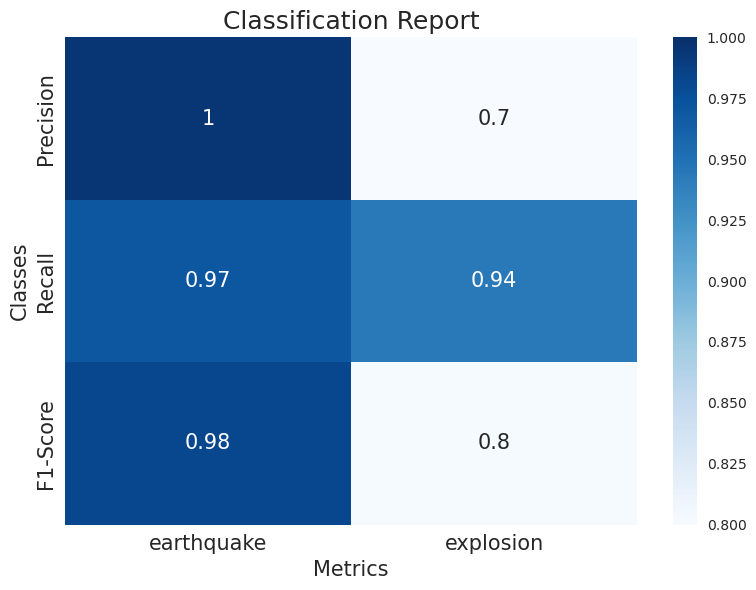

In [166]:
# Calculate the classification report
report_bin = classification_report(test_overall['mean_labels'].values, test_overall['assigned_class'].values, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize = [8,6])
ax = sns.heatmap(pd.DataFrame(report_bin).iloc[:3, :2], annot=True, cmap='Blues', yticklabels=labels, xticklabels = class_labels,  vmin=0.8, vmax=1,  annot_kws=annot_kws)

# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(labels, fontsize=15)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Lets try to understand why including more stations is improving the results. 

In [246]:
## Collecting and storing event ids
files = glob('../data/binary_classification_waveforms/*.mseed')
station_ids = []
for file in tqdm(files):
    st = obspy.read(file)
    st.resample(100)
    if len(st[0].data) == 15000:
        station_ids.append(st[0].id)

100%|██████████| 5538/5538 [00:10<00:00, 541.22it/s]


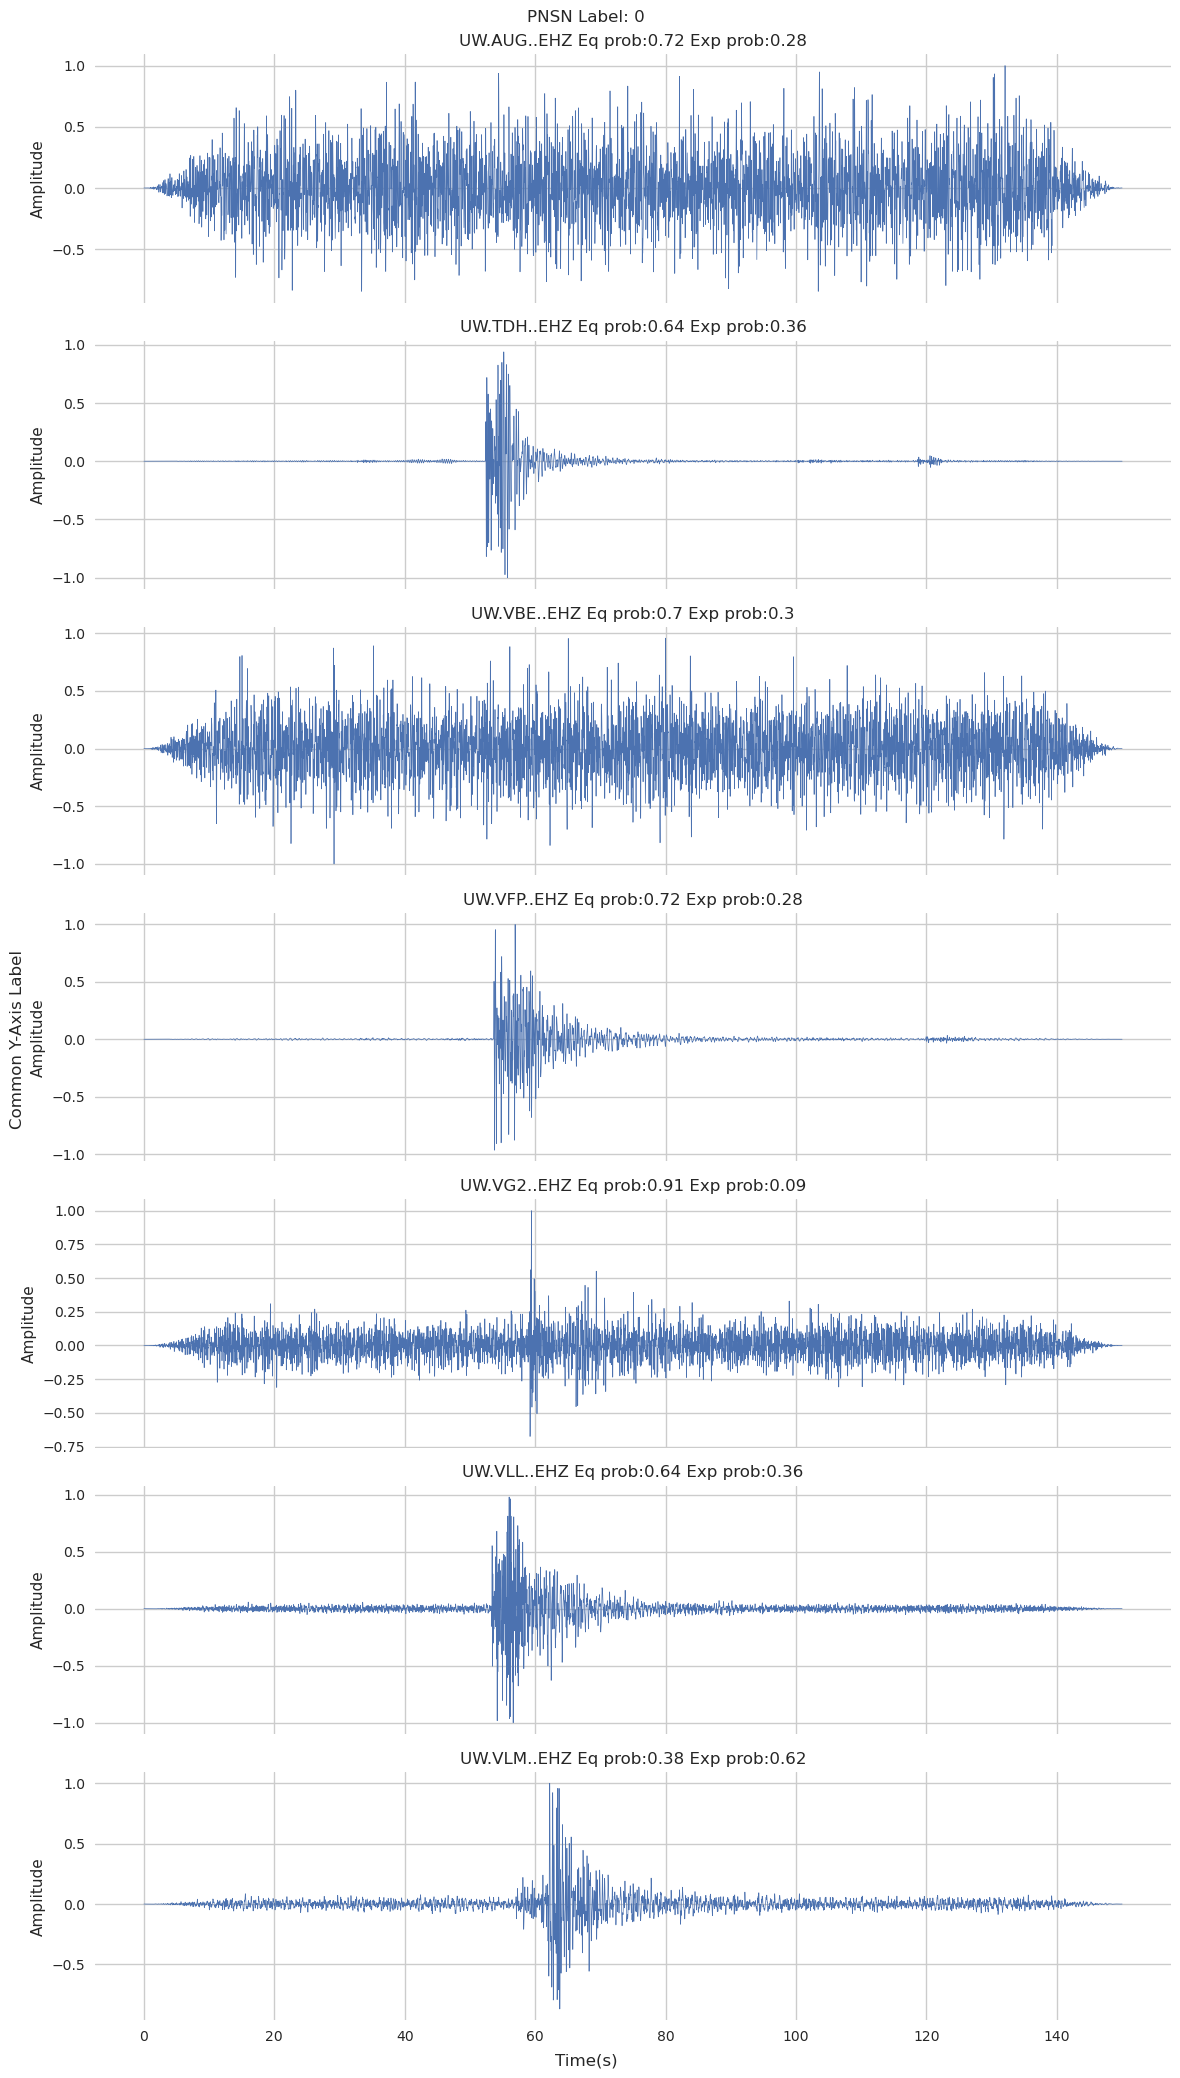

In [286]:
k = 7

## Grabbing the data from the stations
sample_data = norm[np.where(np.array(event_ids) == event_ids_mean[k])[0]]

# Grabbing the station ids 
sample_station_ids = np.array(station_ids)[np.where(np.array(event_ids) == event_ids_mean[k])[0]]

# Grabbing the results
sample_df_here = features_bin[features_bin['event_id'] == event_ids_mean[k]]
sample_eq_probs = sample_df_here['Eq_prob'].values
sample_exp_probs = sample_df_here['Exp_prob'].values


# Grabbing the original labels
original_label = X_test.loc[event_ids_mean[4]]['labelled']

time_here = np.linspace(0, 150, 15000)

# Create a figure and subplots
fig, axs = plt.subplots(nrows=len(sample_data), ncols=1, figsize=(12, 3*len(sample_data)), sharex = True)  # Adjust figsize as needed




# Plot data on each subplot
for i in range(len(sample_data)):
    axs[i].plot(time_here, sample_data[i], lw=0.5)
    #axs[i].set_xlim(40, 80)
    axs[i].set_title(sample_station_ids[i]+' Eq prob:'+str(np.around(sample_eq_probs[i],2))+' Exp prob:'+str(np.around(sample_exp_probs[i], 2)))  # Set title for each subplot
    #axs[i].set_xlabel('Time(s)')  # Set x-axis label (optional)
    axs[i].set_ylabel('Amplitude')  # Set y-axis label (optional)

    
    
# Add common labels to the entire figure
fig.suptitle('PNSN Label: '+str(original_label), y = 0.99)  # Title for the entire figure
fig.supylabel('Common Y-Axis Label')  # Common y-axis label
fig.supxlabel('Time(s)')  # Common x-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the combined figure with subplots
plt.show()


In [195]:
features = scaler_params['Feature'].values
#for i in range(len(scaler_params)):
#    X_test.loc[:,features[i]] = X_test.loc[:,features[i]]*(scaler_params.iloc[i,2]) + scaler_params.iloc[i,1]
    
    
misclassified_df = X_test.loc[misclassified_ids]
misclassified_eq = misclassified_df[misclassified_df['classified'] == 1]
misclassified_exp = misclassified_df[misclassified_df['classified'] == 0]

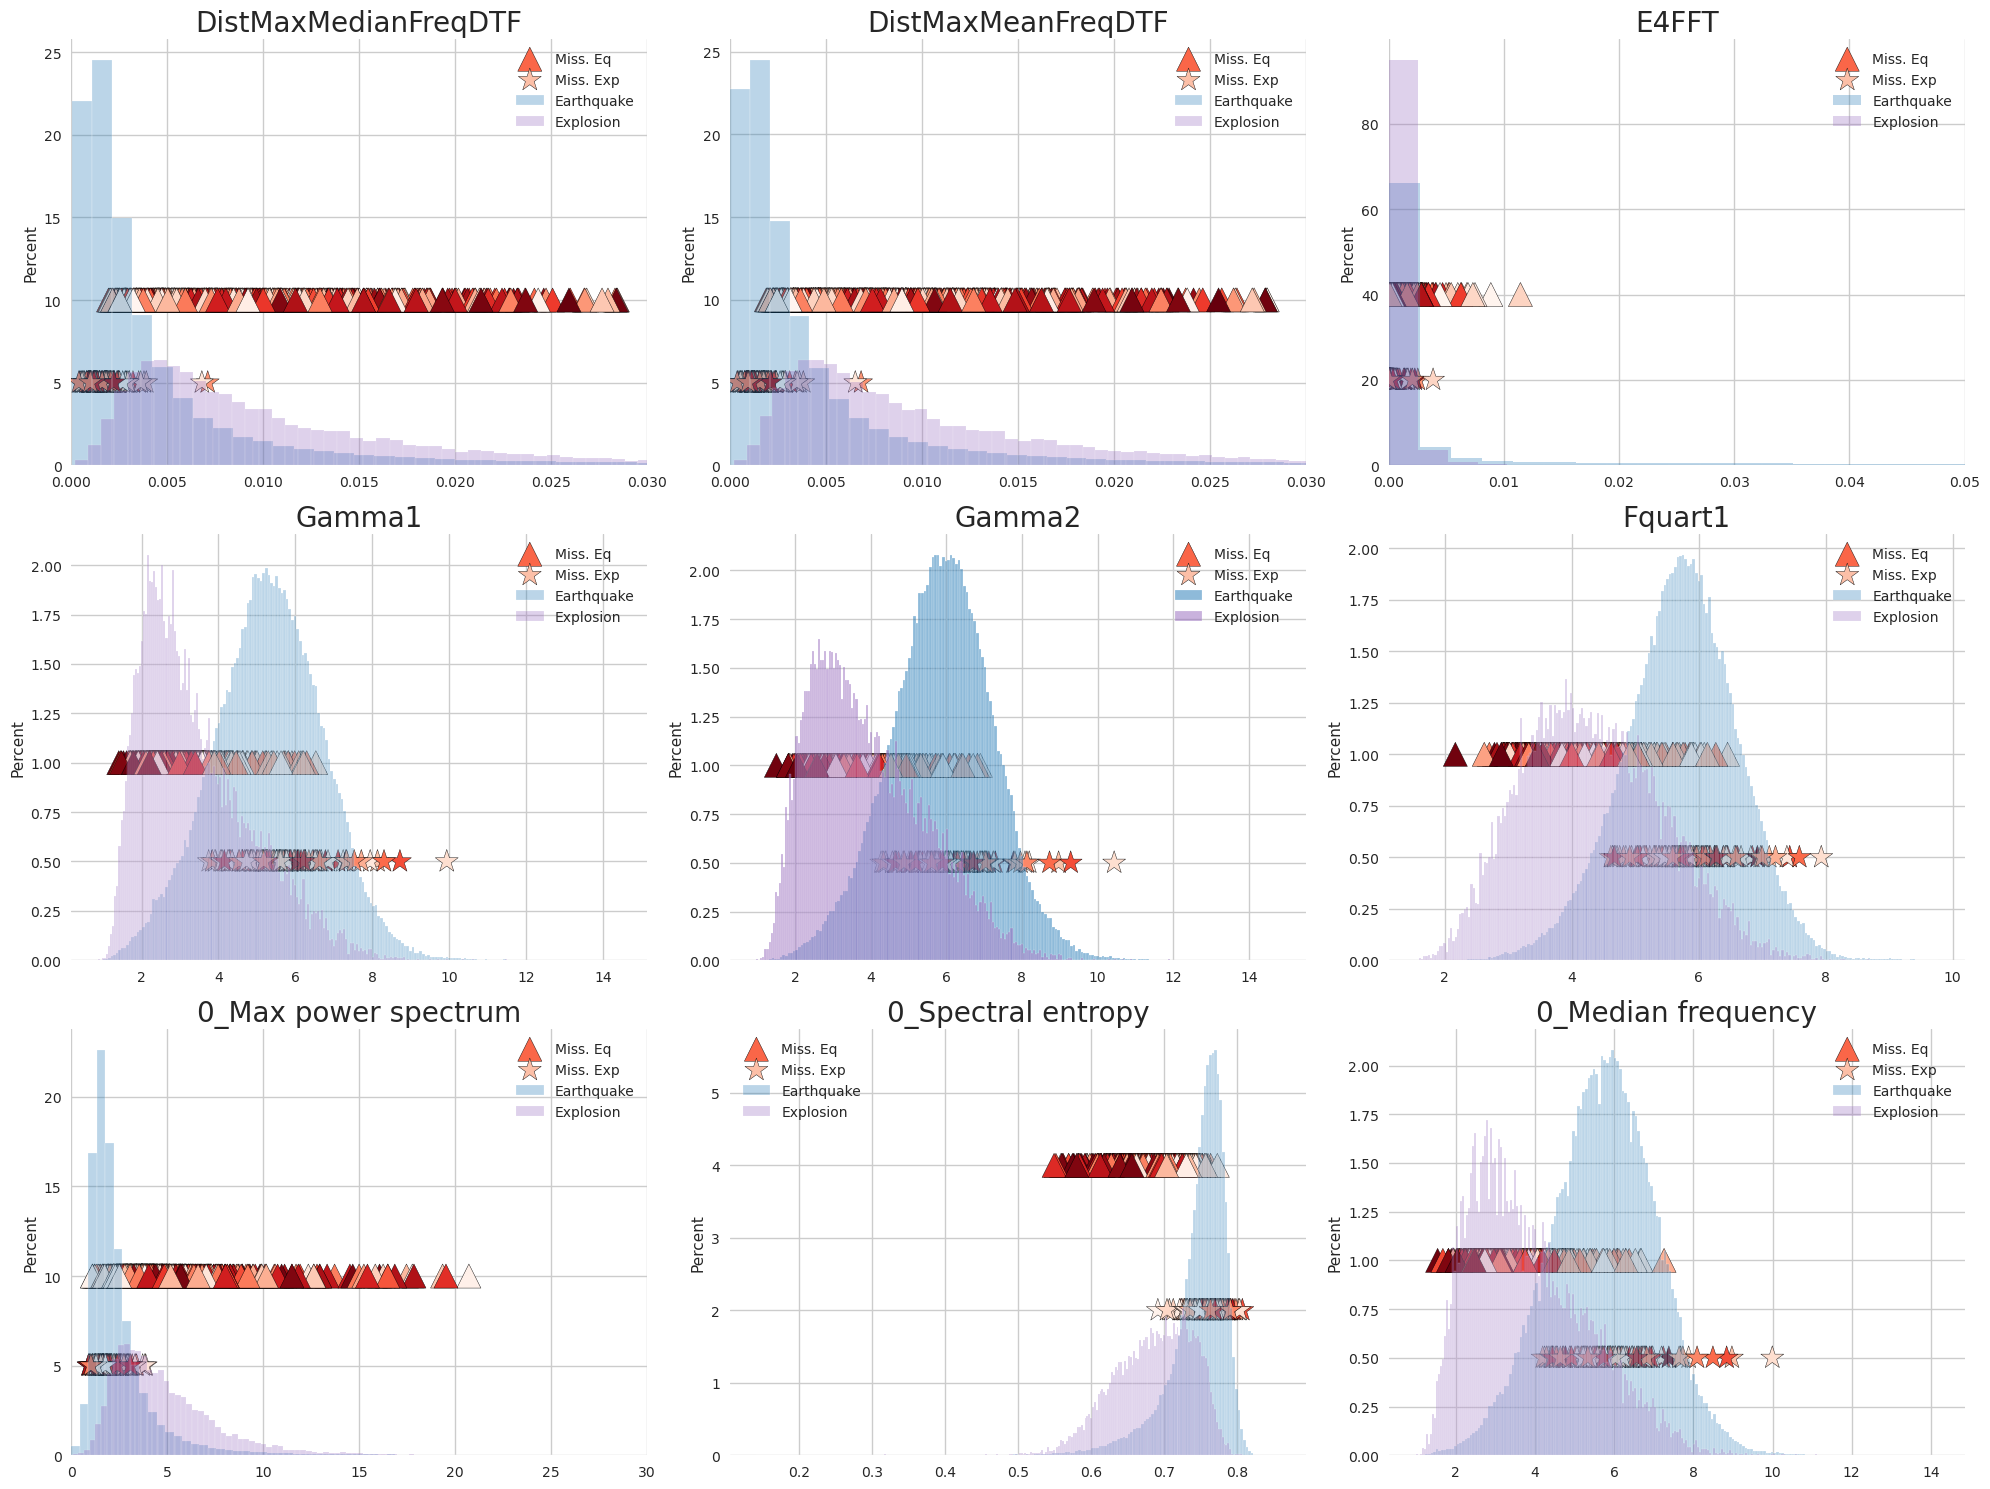

In [196]:
new_eq = features_earthquake_physical
new_exp = features_explosion_physical


fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = [20,15])

feature = 'DistMaxMedianFreqDTF'


l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= features_earthquake_physical[feature].values, bins= num_bins, kde=False, ax = ax[0,0],  
             multiple='stack', stat = 'percent', color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= features_explosion_physical[feature].values, bins=num_bins, kde=False, ax = ax[0,0],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.3, label = 'Explosion')

X_miss_earthquake = misclassified_eq[misclassified_eq['px_probability'] > 0.8]
X_miss_explosion = misclassified_exp[misclassified_exp['eq_probability'] > 0.8]



ax[0,0].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*10, s = 300, ec = 'k', marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[0,0].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*5, s = 300, ec = 'k', marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')


#ax[0,0].scatter(X_miss_explosion[feature].values[np.where(probs_miss_explosion > 0.9)[0]], np.ones(len(X_miss_explosion.iloc[np.where(probs_miss_explosion > 0.9)[0]]))*0.5, s = 50, marker = 'o',ec = 'k',c = probs_miss_explosion[np.where(probs_miss_explosion > 0.9)[0]], cmap = 'magma',label = 'Miss. exp')
ax[0,0].legend()
#ax[0,0].set_xscale('log')
ax[0,0].set_xlim(l1,0.03)




ax[0,0].set_title(feature, fontsize = 20)





feature = 'DistMaxMeanFreqDTF'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[0,1],  
             multiple='stack',  stat = 'percent', color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[0,1],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.3, label = 'Explosion')




ax[0,1].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*10,ec = 'k', s = 300, marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[0,1].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*5,ec = 'k',  s = 300, marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')




ax[0,1].legend()
#ax[0,0].set_xscale('log')
ax[0,1].set_xlim(l1,0.03)


ax[0,1].set_title(feature, fontsize = 20)






feature = 'E4FFT'

l1 = -0.35
l2 = -0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int(data_range/ 0.05)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= 2000, kde=False, ax = ax[0,2],  
             multiple='stack',  stat = 'percent', color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins= 10, kde=False, ax = ax[0,2],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.3, label = 'Explosion')


ax[0,2].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*40,ec = 'k',  s = 300, marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[0,2].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*20, ec = 'k', s = 300, marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')
ax[0,2].legend()
#ax[0,2].set_xscale('log')
ax[0,2].set_xlim(0,0.05)


ax[0,2].set_title(feature, fontsize = 20)




feature = 'Gamma1'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[1,0],  
             multiple='stack',  stat = 'percent', color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[1,0],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.3, label = 'Explosion')
#ax[1,0].scatter(X_miss_earthquake[feature].values[np.where(probs_miss_earthquake > 0.9)[0]], np.ones(len(X_miss_earthquake.iloc[np.where(probs_miss_earthquake > 0.9)[0]]))*1, s = 50, marker = '^',ec = 'k',c = probs_miss_earthquake[np.where(probs_miss_earthquake > 0.9)[0]], cmap = 'magma',label = 'Miss. eqs')
#ax[1,0].scatter(X_miss_explosion[feature].values[np.where(probs_miss_explosion > 0.9)[0]], np.ones(len(X_miss_explosion.iloc[np.where(probs_miss_explosion > 0.9)[0]]))*0.5, s = 50, marker = 'o',ec = 'k',c = probs_miss_explosion[np.where(probs_miss_explosion > 0.9)[0]], cmap = 'magma',label = 'Miss. exp')

ax[1,0].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*1, s = 300, ec = 'k', marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[1,0].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*0.5, s = 300, ec = 'k', marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')

ax[1,0].legend()
#ax[0,0].set_xscale('log')
#ax[0,0].set_xlim(l1,0.02)


ax[1,0].set_title(feature, fontsize = 20)





feature = 'Gamma2'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[1,1],  
             multiple='stack', stat = 'percent', color =  '#1f77b4', alpha = 0.5, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[1,1],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.5, label = 'Explosion')


ax[1,1].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*1, s = 300, ec = 'k', marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[1,1].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*0.5, s = 300, ec = 'k', marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')


ax[1,1].legend()
#ax[0,0].set_xscale('log')
#ax[0,0].set_xlim(l1,0.02)


ax[1,1].set_title(feature, fontsize = 20)






feature = 'Fquart1'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[1,2],  
             multiple='stack',  stat = 'percent', color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[1,2],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.3, label = 'Explosion')


ax[1,2].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*1, s = 300, ec = 'k', marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[1,2].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*0.5, s = 300, ec = 'k', marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')
ax[1,2].legend()
#ax[0,0].set_xscale('log')
#ax[0,0].set_xlim(l1,0.02)


ax[1,2].set_title(feature, fontsize = 20)






new_eq = features_earthquake_tsfel
new_exp = features_explosion_tsfel












feature = '0_Max power spectrum'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[2,0],  
             multiple='stack', stat = 'percent',  color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[2,0],  
             multiple='stack', stat = 'percent', color = '#9467bd', alpha = 0.3, label = 'Explosion')



ax[2,0].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*10, s = 300,ec = 'k', marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[2,0].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*5, s = 300, ec = 'k', marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')
ax[2,0].legend()
#ax[0,0].set_xscale('log')
ax[2,0].set_xlim(0,30)


ax[2,0].set_title(feature, fontsize = 20)






feature = '0_Spectral entropy'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[2,1],  
             multiple='stack', stat = 'percent',  color =  '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[2,1],  
             multiple='stack', stat = 'percent',  color = '#9467bd', alpha = 0.3, label = 'Explosion')


ax[2,1].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*4, s = 300, marker = '^',ec = 'k',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[2,1].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*2, s = 300, marker = '*',ec = 'k', c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')

ax[2,1].legend()
#ax[0,0].set_xscale('log')
#ax[0,0].set_xlim(l1,0.02)


ax[2,1].set_title(feature, fontsize = 20)





feature = '0_Median frequency'

l1 = 0
l2 = 0.1

all_df = features_all
data_range = all_df[feature].values.ptp()
num_bins = int((l2 - l1)/ 0.0005)
#sns.histplot(x= no_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0], 
#             multiple='stack', stat = 'percent', color = 'green', alpha = 0.5,label = 'Noise')
#sns.histplot(x= su_df[feature].values, bins= num_bins, kde=False, ax = ax[0,0],   
#             multiple='stack', stat = 'percent', color = 'red', alpha = 0.5, label = 'Surface')
sns.histplot(x= new_eq[feature].values, bins= num_bins, kde=False, ax = ax[2,2],  
             multiple='stack', stat = 'percent',  color = '#1f77b4', alpha = 0.3, label = 'Earthquake')
sns.histplot(x= new_exp[feature].values, bins=num_bins, kde=False, ax = ax[2,2],  
             multiple='stack', stat = 'percent',  color = '#9467bd', alpha = 0.3, label = 'Explosion')



ax[2,2].scatter(X_miss_earthquake[feature].values, np.ones(len(X_miss_earthquake))*1, ec = 'k',s = 300, marker = '^',c = X_miss_earthquake['px_probability'], cmap = 'Reds',label = 'Miss. Eq')
ax[2,2].scatter(X_miss_explosion[feature].values, np.ones(len(X_miss_explosion))*0.5, ec = 'k', s = 300, marker = '*',c = X_miss_explosion['eq_probability'], cmap = 'Reds',label = 'Miss. Exp')


ax[2,2].legend()
#ax[2,2].colorbar()
#ax[0,0].set_xscale('log')
#ax[0,0].set_xlim(l1,0.02)


ax[2,2].set_title(feature, fontsize = 20)

plt.tight_layout()

In [287]:
st

1 Trace(s) in Stream:
UW.RPW2..HHZ | 2022-12-16T20:45:30.600000Z - 2022-12-16T20:48:00.600000Z | 100.0 Hz, 15001 samples